In [1]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


from synthesize.synthesize import placeRandomRooms, synthesize_train_set, synthetic_sensor
from utils.planning import  get_path, plot_path
from utils.processing import create_classification_problem
from utils.plotting import plot_path_with_lines
from sklearn import preprocessing
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
import random
from copy import deepcopy
import math
from shapely.geometry import LineString
from astar.gridmap import OccupancyGridMap
import argparse
from shapely.geometry import MultiLineString, LineString
from copy import deepcopy

%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
class Args:
    robot_type = 'omni'
    map_size = (50,50)
    num_train_maps = 10
    num_train_paths = 100
    use_polar = True 
    num_sensor_readings = 4
    movement = '4N'
    dirs = {0:(1.0, 0.0), 1:(0.0, 1.0), 2:(-1.0, 0.0), 3:(0.0, -1.0)}
    inv_dirs = {d: label for label, d in dirs.items()}
    enc = preprocessing.LabelEncoder()
    steer = {0:0, 1:np.pi/2., -1:-np.pi/2, 2:np.pi, -2:np.pi, 3:-np.pi/2, -3:np.pi/2}
    img_root = 'gifs'
    
args=Args()

In [6]:
def test_model(MAP, map_np, start, goal, model, args):
    
    groud_truth = get_path(start, goal, map_np, plot=True) 
    print("Number of steps taken in A* Path, ", len(groud_truth))
    pred_path = [start]
    cur_dir = (0, 0)
    cur = start
    directions = []
    while cur != goal:

        laser_scan, lines = synthetic_sensor(MAP, (cur[0]+0.5, cur[1]+0.5), direction=cur_dir, args = args)
        offset = 0
        if cur_dir != (0, 0): # Start node
            offset = args.inv_dirs[cur_dir]
        rot = np.pi/2 * offset 
        goal_loc = (goal[0]-cur[0], goal[1]-cur[1])  
        goal_orn = (goal_loc[0]*np.cos(rot) + goal_loc[1]*np.sin(rot), goal_loc[0]*-np.sin(rot) + goal_loc[1]*np.cos(rot))
        if args.robot_type == 'omni':
            laser_scan.append(goal_loc[0])
            laser_scan.append(goal_loc[1])
        elif args.robot_type == 'ddr':
            if args.use_polar:
                polar_distance = np.linalg.norm(np.array([goal_loc[0],goal_loc[1]]))
                polar_rotation = math.atan2(goal_orn[1], goal_orn[0])
                laser_scan.append(polar_distance)
                laser_scan.append(polar_rotation)
            else:
                laser_scan.append(goal_orn[0])
                laser_scan.append(goal_orn[1])

        # Create model input
        inpX = np.array(laser_scan)
        inds = model.predict_proba(inpX.reshape(1,-1))[0]
        best = list(np.argsort(inds))  
        best.reverse()

        possible_dirs = [eval(args.enc.inverse_transform(best)[ii]) for ii in range(len(best))]
        if args.robot_type == 'omni':
            possible_next_states = [(cur[0] + d[0], cur[1] + d[1]) for d in possible_dirs]
        elif args.robot_type == 'ddr':
            possible_steers = [(np.cos(rot + args.steer[ind]), np.sin(rot + args.steer[ind])) for ind in possible_dirs]
            possible_next_states = [(cur[0] + steers[0], cur[1] + steers[1]) for steers in possible_steers]

        temp_states = deepcopy(possible_next_states)
        for state in possible_next_states:
            if (state in pred_path):
                temp_states.remove(state) 

        directions.append(cur_dir)
        cur_dir = (temp_states[0][0] - cur[0], temp_states[0][1] - cur[1])
        cur = temp_states[0]

        assert cur not in pred_path
        pred_path.append(cur)
        if cur == goal:
            temp = [(p[0]+0.5, p[1]+0.5) for p in pred_path]
            if LineString(temp).intersects(MAP):
                success = 0
            else:
                success = 1
            break
 
    return pred_path, directions, success, groud_truth

In [7]:
MAPS = []

for i in range(args.num_train_maps):
    train_arr, train_MAP = placeRandomRooms(args.map_size, minRoomSize=3, maxRoomSize=15, roomStep = 1, margin = 4, attempts = 100)
    MAPS.append((train_MAP,train_arr))

df_ = synthesize_train_set(MAPS, args)
df = create_classification_problem(df_.copy(), args)

# Fit model using all data.
clf = RandomForestClassifier(n_estimators=200)
clf.fit(df.drop(['out'], axis=1).values, df['out'].values)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.24it/s]


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

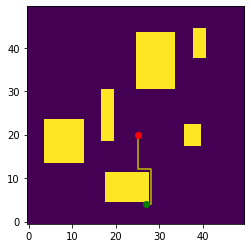

Number of steps taken in A* Path,  21


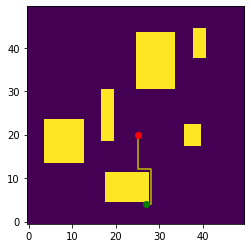

Number of steps taken in pred Path 21
Safe path found!


In [8]:
pred_len = []
astar_len = []
n_test = 0
successes = 0
avgs = []
while n_test < 1:

    min_node, max_node = 1, args.map_size[1]-1
    start = (random.randint(min_node, max_node), random.randint(min_node, max_node))
    goal = (random.randint(min_node, max_node), random.randint(min_node, max_node))
    arr, test_MAP = placeRandomRooms(args.map_size, minRoomSize=3, maxRoomSize=15, roomStep = 1, margin = 4, attempts = 100)
    try:
        pred_path, directions, success, ground_truth = test_model(test_MAP, arr, start, goal, clf, args)
        OccupancyGridMap(arr, 1).plot()
        plot_path(pred_path)
        pred_len.append(len(pred_path))
        print('Number of steps taken in pred Path', len(pred_path))
        astar_len.append(len(get_path(start, goal, arr, False)))
        if success == 1:
            print("Safe path found!")
            avgs.append(len(pred_path)- len(ground_truth) )
        else:
            print("Invalid path computed :(")
        break
    except:
        continue

In [ ]:
from IPython.display import Image
plot_path_with_lines(pred_path[:-1], test_MAP, directions, args)
Image(args.img_root+'/out.gif')